# DataLab Cup 4 : Unlearnable Dataset
`Neural Tangent Generalization Attacks (NTGA)`

# Dataset Download
CAUTION: If you nerver download dataset from Kaggle before, plz follow the tutorial in this page: https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

## CIFAR-10

In [ ]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-cifar-10

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-cifar-10.zip'
zip_list(file_path)

## Imagenet

In [ ]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-imagenet

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-imagenet.zip'
zip_list(file_path)

# Libraries and Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!nvidia-smi

Sun Jan 16 23:02:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 31%   49C    P8    10W / 250W |     14MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 32%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[1], True)
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Hyperparameter

In [4]:
MODE = 'cifar10'
# MODE = 'imagenet'

if MODE == 'cifar10':
    BATCH_SIZE = 128
    NUM_CLASSES = 10
    IMAGE_HEIGHT = 32
    IMAGE_WIDTH = 32
if MODE == 'imagenet':
    BATCH_SIZE = 128
    NUM_CLASSES = 2
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    
IMAGE_CHANNEL = 3

# Dataset

In [5]:
x_train = np.load(f'./dataset/x_train_{MODE}_unlearn.npy')
y_train = np.load(f'./dataset/y_train_{MODE}.npy')
x_val = np.load(f'./dataset/x_val_{MODE}.npy')
y_val = np.load(f'./dataset/y_val_{MODE}.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

## Denoising Autoencoder

In [6]:
def noise(array, noise_factor=0.4):
    """
    Adds random noise to each image in the supplied array.
    """

    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Add noise to original image

In [7]:
from skimage.util import random_noise

noise_g = random_noise(x_train, mode='gaussian', clip=True, mean=0, var=0.003) - x_train
# noise_sp = random_noise(x_train, mode='s&p', clip=True, salt_vs_pepper=0.5, amount=0.02) - x_train
# noise_p = random_noise(x_train, mode='poisson', clip=True) - x_train
# noise_s = random_noise(x_train, mode='speckle', clip=True, mean=0, var=0.01) - x_train

x_train = x_train + noise_g#+ noise_sp + noise_p + noise_s

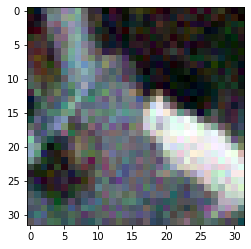

In [8]:
idx = np.random.randint(len(x_train))
plt.imshow(x_train[5])

## Data augmentation

In [9]:
MAPPING_FUNC = None

def vertical_flip(tf_img):
    return tf.image.flip_left_right(tf_img)

def horizontal_flip(tf_img):
    return tf.image.flip_up_down(tf_img)

def brightness(tf_img):
    return tf.image.random_brightness(tf_img, 0.2, 2)

def central_crop(tf_img):
    img = tf.image.central_crop(tf_img, 0.8)
    # img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return img

def noise_injection(tf_img):
    noise = tf.random.normal(shape=tf.shape(tf_img), mean=0.0, stddev=1, dtype=tf.float32)
    return tf.add(tf_img, noise)

def grayscale(tf_img):
    img = tf.image.rgb_to_grayscale(tf_img)
    return tf.repeat(img, 3, -1)

def data_generator(image, label):
    # img = tf.cast(image, tf.float32)
    # img.set_shape([None, None, IMAGE_CHANNEL])
    img = image
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)

    if MAPPING_FUNC is not None:
        img = MAPPING_FUNC(img)

    img = img * 255
    img = tf.keras.applications.resnet50.preprocess_input(img) # -1~1
    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    # img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    label = tf.cast(label, tf.int32)    
    return img, label

def transform_dataset(image, label):
    dataset = tf.data.Dataset.from_tensor_slices((image, label))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(label))
    return dataset

In [10]:
MAPPING_FUNC = None
original_dataset = transform_dataset(x_train, y_train)

MAPPING_FUNC = grayscale
gray_dataset = transform_dataset(x_train, y_train)

MAPPING_FUNC = vertical_flip
vertical_dataset = transform_dataset(x_train, y_train)

MAPPING_FUNC = horizontal_flip
horizontal_dataset = transform_dataset(x_train, y_train)

MAPPING_FUNC = brightness
brightness_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = central_crop
# crop_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = noise_injection
# noise_dataset = transform_dataset(x_train, y_train)

train_dataset = original_dataset
# train_dataset = train_dataset.concatenate(gray_dataset)
train_dataset = train_dataset.concatenate(vertical_dataset)
train_dataset = train_dataset.concatenate(horizontal_dataset)
train_dataset = train_dataset.concatenate(brightness_dataset)
# train_dataset = train_dataset.concatenate(crop_dataset)
# train_dataset = train_dataset.concatenate(noise_dataset)
batched_dataset = train_dataset.shuffle(len(y_train)).batch(BATCH_SIZE, drop_remainder=True)
batched_dataset = batched_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(f'Batch size: {BATCH_SIZE}, # of batch: {len(batched_dataset)}')
print(f'Total images: {len(batched_dataset)*BATCH_SIZE}')

Batch size: 128, # of batch: 1250
Total images: 160000


In [11]:
MAPPING_FUNC = None
val_dataset = transform_dataset(x_val, y_val)
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 5
(32, 32, 3)


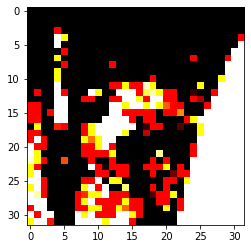

In [12]:
for data in batched_dataset.take(1):
    idx = 36
    print("Class:", data[1][idx].numpy())
    for i in range(len(data[0])):
        assert data[0][i].shape == (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
    print(data[0][idx].shape)
    plt.imshow((data[0][idx]),cmap='gray')

# Model

In [13]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    # x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    return x

In [14]:
# input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
# densenet121 = tf.keras.applications.DenseNet121(
#     input_shape=input_shape,
#     include_top=False,
#     weights=None,
#     classes=NUM_CLASSES)
# densenet121.trainable = False

# inputs = keras.Input(shape=input_shape)
# x = densenet121(inputs, training=False)

# x = conv_leaky_relu(x, 128, 3, 1)
# x = conv_leaky_relu(x, 128, 3, 1)

# x = layers.Flatten()(x)
# x = layers.Dense(128)(x)
# x = layers.LeakyReLU(0.1)(x)
# x = layers.Dense(128, activation='relu')(x)
# outputs = layers.Dense(NUM_CLASSES)(x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
# model.summary()

In [15]:
resnet = tf.keras.applications.ResNet50(
    include_top=False, 
    input_tensor=keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)),
    pooling='max',
    weights=None)

input = resnet.input
output = layers.Dense(NUM_CLASSES)(resnet.output)

model = keras.Model(input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

# Training

In [16]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [17]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=100)

Epoch 1/100


2022-01-16 23:02:34.863722: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-16 23:02:34.870183: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-16 23:02:34.910136: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-16 23:02:34.920209: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

1250/1250 [==============================] - 76s 57ms/step - loss: 2.1288 - acc: 0.2895 - val_loss: 2.0711 - val_acc: 0.2932
Epoch 2/100
1250/1250 [==============================] - 72s 56ms/step - loss: 1.8743 - acc: 0.3690 - val_loss: 5.0853 - val_acc: 0.2687
Epoch 3/100
1250/1250 [==============================] - 72s 57ms/step - loss: 1.7238 - acc: 0.4131 - val_loss: 1.5263 - val_acc: 0.4678
Epoch 4/100
1250/1250 [==============================] - 72s 57ms/step - loss: 1.6022 - acc: 0.4646 - val_loss: 129.6152 - val_acc: 0.2387
Epoch 5/100
1250/1250 [==============================] - 72s 57ms/step - loss: 1.9301 - acc: 0.3483 - val_loss: 14.0851 - val_acc: 0.2911
Epoch 6/100
1250/1250 [==============================] - 72s 57ms/step - loss: 1.8802 - acc: 0.3519 - val_loss: 7.6487 - val_acc: 0.3045
Epoch 7/100
1250/1250 [==============================] - 72s 57ms/step - loss: 1.6856 - acc: 0.4153 - val_loss: 1.7682 - val_acc: 0.4095
Epoch 8/100
1250/1250 [===========================

# Visualize

In [18]:
np.mean(history.history['val_acc'])

0.606914059817791

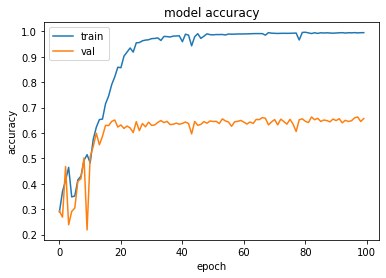

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 200 epoch

In [ ]:
# grayscale

# Inference

In [ ]:
x_test = np.load(f'./dataset/x_test_{MODE}.npy')
print(x_test.shape)
x_test = autoencoder.predict(x_test)
print(x_test.shape)

In [20]:
def test_data_generator(image):
    # img = tf.cast(image, tf.float32)
    # img.set_shape([None, None, IMAGE_CHANNEL])
    
    img = image
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)

    img = img * 255
    img = tf.keras.applications.resnet50.preprocess_input(img)

    # img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    # img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return img

In [21]:
x_test = np.load(f'./dataset/x_test_{MODE}.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
test_dataset = test_dataset.map(test_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
print(len(x_test), len(test_dataset), len(batched_test_dataset))

10000 10000 79


In [22]:
result = model.predict(x=batched_test_dataset)
final_result = np.argmax(result, axis=1)
output = pd.DataFrame({'id':range(len(final_result)), 'label':final_result})
output.to_csv(f'./submission_{MODE}.csv', header=True, index=False)

2022-01-17 01:04:20.789549: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-17 01:04:20.793795: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
